## Техническое задание 

Интернет-магазин (одежды, судя по названию датасетов) собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в течение 90 дней.
<br>Цель:
<br>Предсказать вероятность покупки в течение 90 дней
<br>Задачи:
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc (граница: 0.7)
- Выполнить тестирование

In [1]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import os
from datetime import datetime
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Подготовка данных
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Для пайплайна
from sklearn.pipeline import Pipeline

# Модели и метрика
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
pd.set_option('display.max_columns', None)

In [2]:
pip freeze > requirements.txt  # выгрузка requirements

Note: you may need to restart the kernel to use updated packages.


## Информация о данных

In [3]:
def get_percent(num_1, num_2):

    '''функция для быстрого расчета процента одного числа от другого'''
    
    return round((num_1 * 100 / num_2), 2)

def read_df_csv(names, new_names, sep=','):      
    
    '''принимает список имен датасетов, которые находятся в директории /datasets/ 
    и помещает их в переменные data_1,_2,_3 и т.д.'''
    
    for i, c in enumerate(names):       
        globals().update({new_names[i] : pd.read_csv('/home/ilya/Рабочий стол/YPrac/12.m_market/'+c, sep=sep)})   

def show_info_about_df(list_df):
    
    '''выводит информацию о всех датасетах из списка list_df'''
    
    for c, i in enumerate(list_df):
        print("**** DATASET_"+str(c+1)+' ****')
        display(i.info())
        display(i.describe().round(2))
        dubl = i.duplicated().sum()
        print(f'Количество дубликатов: {dubl} ({get_percent(dubl, len(i))}%) ')
        print('Количество пропущенных значений:', i.isnull().sum())
        print()

In [4]:
# выгрузим неагрегированные данные 

names = ['apparel-messages.csv', 'apparel-purchases.csv', 'apparel-target_binary.csv'] 
dfs = ['apparel_messages', 'apparel_purchases', 'apparel_target']

read_df_csv(names, dfs)

In [5]:
dfs = [apparel_messages, apparel_purchases, apparel_target]

for i in dfs:
    display(i.head(3))

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0


In [6]:
show_info_about_df(dfs)

**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

,bulk_campaign_id,client_id
count,12739798.00,1.273980e+07
mean,11604.59,1.515916e+18
std,3259.21,3.265518e+08
min,548.00,1.515916e+18
25%,8746.00,1.515916e+18
50%,13516.00,1.515916e+18
75%,14158.00,1.515916e+18
max,14657.00,1.515916e+18


Количество дубликатов: 48610 (0.38%) 
Количество пропущенных значений: bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

**** DATASET_2 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

,client_id,quantity,price
count,2.022080e+05,202208.00,202208.00
mean,1.515916e+18,1.01,1193.30
std,1.459514e+08,0.18,1342.25
min,1.515916e+18,1.00,1.00
25%,1.515916e+18,1.00,352.00
50%,1.515916e+18,1.00,987.00
75%,1.515916e+18,1.00,1699.00
max,1.515916e+18,30.00,85499.00


Количество дубликатов: 73020 (36.11%) 
Количество пропущенных значений: client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

**** DATASET_3 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,client_id,target
count,4.984900e+04,49849.00
mean,1.515916e+18,0.02
std,1.487947e+08,0.14
min,1.515916e+18,0.00
25%,1.515916e+18,0.00
50%,1.515916e+18,0.00
75%,1.515916e+18,0.00
max,1.515916e+18,1.00


Количество дубликатов: 0 (0.0%) 
Количество пропущенных значений: client_id    0
target       0
dtype: int64



**Вывод**
<br> Представленные данные состоят из 5 датасетов:
<br>*apparel_purchases* - данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.
<br>*apparel_messages* - рассылки, которые были отправлены клиентам из таблицы покупок.
<br>*apparel_target* - информация о совершенной покупке клиентом.
<br>
<br>Самый объемный датасет - apparel_messages(680 МВ) содержит ок. 12.7 млн. строк из них 48610 дубликатов (0.38%).
<br>apparel_purchases содержит ок. 202 тыс. строк, из которых 73020 дубликатов (36.11%).
<br>apparel_target содержит ок. 50 тыс. строк. Дубликаты отсутствуют. Также видно, что среднее по таргету = 0.02. Это означает, что из всех клентов покупки совершили всего около 2%.
<br>Пропусков в данных нет; дубликаты, аномальные значения, уменьшение размерности будут обработаны в следующем разделе.

## Предобработка данных и генерация новых признаков

Вначале устраним дубликаты в apparel_messages. Поскольку их мало (0.38%) то их смело удалим.

In [7]:
len(apparel_messages)

12739798

In [8]:
apparel_messages = apparel_messages.drop_duplicates().reset_index(drop=True)
len(apparel_messages)

12691188

Заменим тип колонок с датами на datetime:

In [9]:
dfs = [apparel_messages, apparel_purchases] #full_campaign_daily_event, full_campaign_daily_event_channel]

for i in dfs:
    i['date'] = pd.to_datetime(i['date'])

apparel_messages['created_at'] = pd.to_datetime(apparel_messages['created_at'])

Займемся категориями. Для определения самых частых категорий в *apparel_purchases* вначале посчитаем максимальное количество категорий у клиентов. Для этого удалим из колонки **category_ids** символы: [ ] ' и пробел и посчитаем количество запятых. Категорий будет на 1 больше

In [10]:
apparel_purchases['category_ids'] = apparel_purchases['category_ids'].str.replace("[", "")\
                                                                     .str.replace("]", "")\
                                                                     .str.replace("'", "")\
                                                                     .replace(' ', '')

f'максимальное число категорий: {apparel_purchases['category_ids'].str.count(',').max()+1}'

'максимальное число категорий: 5'

In [11]:
cats = ['cat_' + str(i+1) for i in range(5)]

apparel_purchases[['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5']] = apparel_purchases['category_ids'].str.split(',', n=4, expand=True)
apparel_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,cat_1,cat_2,cat_3,cat_4,cat_5
0,1515915625468169594,1,1999.0,"4, 28, 57, 431",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,None
1,1515915625468169594,1,2499.0,"4, 28, 57, 431",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,None
2,1515915625471138230,1,6499.0,"4, 28, 57, 431",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,None
3,1515915625471138230,1,4999.0,"4, 28, 244, 432",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,None
4,1515915625471138230,1,4999.0,"4, 28, 49, 413",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,None


Видно, что каждая последующая категория больше предыдущей. Проверим, есть ли для каждой категории множество предыдущих или только одна:

In [12]:
for i in range(4):
    print(f'Для {cats[i+1]} уникальных предыдущих категорий: {apparel_purchases.groupby(cats[i+1])[cats[i]].nunique().sum()}')
    print(f'Всего уникальных категорий в {cats[i+1]}: {len(apparel_purchases.groupby(cats[i+1]))}')
    print()

Для cat_2 уникальных предыдущих категорий: 31
Всего уникальных категорий в cat_2: 31

Для cat_3 уникальных предыдущих категорий: 294
Всего уникальных категорий в cat_3: 291

Для cat_4 уникальных предыдущих категорий: 903
Всего уникальных категорий в cat_4: 838

Для cat_5 уникальных предыдущих категорий: 1
Всего уникальных категорий в cat_5: 1



Лучше всего будет оставить только третью категорию, т.к. для нее уникальных значений больше всего (для точности).

In [13]:
apparel_purchases = apparel_purchases.drop(['cat_1', 'cat_2','cat_4', 'cat_5', 'category_ids'], axis=1)
apparel_purchases

,client_id,quantity,price,date,message_id,cat_3
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,57
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,57
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,57
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,244
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,49
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,212
202204,1515915626010439406,1,99.0,2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,233
202205,1515915626010439406,1,99.0,2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,233
202206,1515915626010443527,1,1999.0,2024-02-16,1515915625766077627-14668-65cf5246bd490,274


In [14]:
# посмор=трим, сколько уникальных клиентов есть в датасетах
dfs = [apparel_messages, apparel_purchases, apparel_target]

for i in dfs:
    print(i['client_id'].nunique())

53329
49849
49849


В *apparel_messages* киентов больше, лишние данные удалятся при объединении.

Сагрегируем датасет *apparel_purchases*. В новом агрегированном датасете оставим следующие колонки:
<br>**cnt_goods** - количество разных товаров;
<br>**revenue** - выручка от одного клиента;
<br>**median_price** - средняя цена покупки;
<br>**purchase_count** - общее количество покупок клиента;
<br>**unique_cats** - количество уникальных категорий клиента;
<br>**cnt_messages** - количество сообщений для клиента.
<br>**min_date** - первая дата покупки;
<br>**max_date** - последняя дата покупки;
<br>**days_between_buys** - число дней между покупками;
<br>**last_buy** - сколько дней назад была последняя покупка;

Для расчета выручки от каждого клиента создадим столбец **revenue**:

In [15]:
apparel_purchases['revenue'] = apparel_purchases['price'] * apparel_purchases['quantity']

In [16]:
max_date = apparel_purchases.date.max()  # последняя дата покупки кого-либо

pur_agg = apparel_purchases.groupby('client_id').agg({'client_id': 'count',
                                                 'revenue': 'sum',
                                                 'price': 'median',
                                                 'quantity': 'count',
                                                 'cat_3': 'nunique',
                                                 'message_id': 'nunique',
                                                 'date': ['min', 'max']}).reset_index()

pur_agg.columns = ['client_id', 'cnt_goods', 'revenue',    # переименуем колонки
              'median_price', 'purchase_count', 'nunique_cats',
              'cnt_message', 'min_date', 'max_date']

# Добавляем новые признаки
pur_agg['days_between_buys'] = (pur_agg['max_date'] - pur_agg['min_date'])
pur_agg['last_buy'] = (max_date - pur_agg['max_date'])

#удалим ненужные даты
pur_agg = pur_agg.drop(['min_date', 'max_date'], axis=1)

In [17]:
pur_agg

,client_id,cnt_goods,revenue,median_price,purchase_count,nunique_cats,cnt_message,days_between_buys,last_buy
0,1515915625468060902,7,6993.0,999.0,7,5,1,0 days,630 days
1,1515915625468061003,7,16235.0,2100.0,7,1,1,0 days,408 days
2,1515915625468061099,1,299.0,299.0,1,1,1,0 days,640 days
3,1515915625468061100,2,2098.0,1049.0,2,1,1,0 days,6 days
4,1515915625468061170,19,33601.0,2195.0,19,3,3,83 days,244 days
...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,6,8994.0,1499.0,6,1,1,0 days,0 days
49845,1515915626010266132,2,1818.0,909.0,2,1,1,0 days,2 days
49846,1515915626010439406,2,198.0,99.0,2,1,1,0 days,0 days
49847,1515915626010443527,1,1999.0,1999.0,1,1,1,0 days,0 days


Ранее было обнаружено много дублей в данном датафрейме. Посмотрим, сколько теперь осталось:

In [18]:
pur_agg.duplicated().sum()

0

Теперь обработаем для группировки датафрейм *apparel_messages*.

**message_cnt** - количество сообщений для клиента;
<br>**events** - уникальные события;
<br>**bulk_campaign** - количество уникальных рассылок;
<br>**channels** - количество уникальных каналов для рассылок;
<br>**min_date** - первая дата сообщения;
<br>**max_date** - последняя дата сообщения;
<br>**days_between_mess** - число дней между сообщениями (первым и последним);
<br>**last_mess** - сколько дней назад было последнее сообщение.

In [19]:
max_date = apparel_messages.date.max()  # последняя дата покупки кого-либо

mess_agg = apparel_messages.groupby('client_id').agg({'message_id': 'count',
                                                 'event': 'nunique',
                                                 'bulk_campaign_id': 'nunique',
                                                 'channel': 'nunique',
                                                 'date': ['min', 'max']}).reset_index()

mess_agg.columns = ['client_id', 'message_cnt', 'events',    # переименуем колонки
              'bulk_campaign', 'channels', 'min_date', 
              'max_date']

# Добавляем новые признаки
mess_agg['days_between_mess'] = mess_agg['max_date'] - mess_agg['min_date']
mess_agg['last_mess'] = max_date - mess_agg['max_date']

#удалим ненужные даты
mess_agg = mess_agg.drop(['min_date', 'max_date'], axis=1)

mess_agg

,client_id,message_cnt,events,bulk_campaign,channels,days_between_mess,last_mess
0,1515915625468060902,177,5,127,1,610 days,27 days
1,1515915625468061003,165,4,154,1,634 days,2 days
2,1515915625468061099,276,4,215,2,635 days,2 days
3,1515915625468061100,428,6,265,1,637 days,0 days
4,1515915625468061170,293,4,240,2,631 days,0 days
...,...,...,...,...,...,...,...
53324,1515915626010183608,4,2,2,1,0 days,0 days
53325,1515915626010221592,6,3,2,1,0 days,0 days
53326,1515915626010234726,1,1,1,1,0 days,0 days
53327,1515915626010261344,3,3,1,1,0 days,0 days


In [20]:
# объеденим два датафрейма в один
data = pur_agg.merge(mess_agg, on='client_id', how='left').merge(apparel_target, on='client_id', how='left')

# пропуски заполним нулями
data = data.fillna(0)   

# восстановим форматы
data['days_between_mess'] = pd.to_timedelta(data['days_between_mess'])  
data['last_mess'] = pd.to_timedelta(data['last_mess'])

data

,client_id,cnt_goods,revenue,median_price,purchase_count,nunique_cats,cnt_message,days_between_buys,last_buy,message_cnt,events,bulk_campaign,channels,days_between_mess,last_mess,target
0,1515915625468060902,7,6993.0,999.0,7,5,1,0 days,630 days,177.0,5.0,127.0,1.0,610 days,27 days,0
1,1515915625468061003,7,16235.0,2100.0,7,1,1,0 days,408 days,165.0,4.0,154.0,1.0,634 days,2 days,1
2,1515915625468061099,1,299.0,299.0,1,1,1,0 days,640 days,276.0,4.0,215.0,2.0,635 days,2 days,0
3,1515915625468061100,2,2098.0,1049.0,2,1,1,0 days,6 days,428.0,6.0,265.0,1.0,637 days,0 days,0
4,1515915625468061170,19,33601.0,2195.0,19,3,3,83 days,244 days,293.0,4.0,240.0,2.0,631 days,0 days,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,6,8994.0,1499.0,6,1,1,0 days,0 days,3.0,3.0,1.0,1.0,0 days,0 days,0
49845,1515915626010266132,2,1818.0,909.0,2,1,1,0 days,2 days,0.0,0.0,0.0,0.0,0 days,0 days,0
49846,1515915626010439406,2,198.0,99.0,2,1,1,0 days,0 days,0.0,0.0,0.0,0.0,0 days,0 days,0
49847,1515915626010443527,1,1999.0,1999.0,1,1,1,0 days,0 days,0.0,0.0,0.0,0.0,0 days,0 days,0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   client_id          49849 non-null  int64          
 1   cnt_goods          49849 non-null  int64          
 2   revenue            49849 non-null  float64        
 3   median_price       49849 non-null  float64        
 4   purchase_count     49849 non-null  int64          
 5   nunique_cats       49849 non-null  int64          
 6   cnt_message        49849 non-null  int64          
 7   days_between_buys  49849 non-null  timedelta64[ns]
 8   last_buy           49849 non-null  timedelta64[ns]
 9   message_cnt        49849 non-null  float64        
 10  events             49849 non-null  float64        
 11  bulk_campaign      49849 non-null  float64        
 12  channels           49849 non-null  float64        
 13  days_between_mess  49849 non-null  timedelta64

**Вывод**
<br>fgbd

## EDA 

Посмотрим на описание созданного датафрейма:

In [22]:
data.describe()

,client_id,cnt_goods,revenue,median_price,purchase_count,nunique_cats,cnt_message,days_between_buys,last_buy,message_cnt,events,bulk_campaign,channels,days_between_mess,last_mess,target
count,4.984900e+04,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849,49849,49849.000000,49849.000000,49849.000000,49849.000000,49849,49849,49849.000000
mean,1.515916e+18,4.056410,4865.584264,1460.031896,4.056410,1.725030,1.170174,21 days 03:10:22.014483741,361 days 22:21:29.670805840,218.925094,3.389978,156.885534,1.248852,443 days 18:34:19.515737528,32 days 11:02:00.532006660,0.019278
std,1.487947e+08,5.521669,7351.467229,1398.683761,5.521669,1.388864,0.576680,76 days 20:13:23.836373667,185 days 07:14:26.089758640,173.932044,1.679796,116.782900,0.708920,255 days 03:38:34.830891188,108 days 21:42:18.441318106,0.137503
min,1.515916e+18,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0 days 00:00:00,0 days 00:00:00,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00,0 days 00:00:00,0.000000
25%,1.515916e+18,1.000000,1499.000000,629.000000,1.000000,1.000000,1.000000,0 days 00:00:00,233 days 00:00:00,81.000000,3.000000,58.000000,1.000000,195 days 00:00:00,0 days 00:00:00,0.000000
50%,1.515916e+18,2.000000,2969.000000,1221.000000,2.000000,1.000000,1.000000,0 days 00:00:00,348 days 00:00:00,200.000000,4.000000,150.000000,1.000000,629 days 00:00:00,0 days 00:00:00,0.000000
75%,1.515916e+18,5.000000,5698.000000,1999.000000,5.000000,2.000000,1.000000,0 days 00:00:00,542 days 00:00:00,321.000000,4.000000,240.000000,2.000000,636 days 00:00:00,2 days 00:00:00,0.000000
max,1.515916e+18,346.000000,540408.000000,53499.000000,346.000000,34.000000,27.000000,636 days 00:00:00,641 days 00:00:00,3088.000000,8.000000,2465.000000,2.000000,637 days 00:00:00,637 days 00:00:00,1.000000


У численных признаков много значений, которые сильно заходят за 75% квантиль. Посмотрим, сколько значений переваливает за 99.5% квантиль:

In [23]:
temp = ['cnt_goods', 'revenue', 'median_price',   # колонки с большими максимальными значениями
        'purchase_count', 'nunique_cats', 'cnt_message',
        'last_buy', 'message_cnt', 'bulk_campaign']

id_set = set()
len_data = len(data)   # длина датасета

print('Далее 99.5% квантиля:')
for i in temp:
    quant = np.quantile(data[i], .995)   # 99.5% квантиль
    print(f'Признак: {i}: {get_percent(len(data[data[i] > quant]), len_data)}%')
    
    set_clients_above_995 = set(data[data[i] > quant]['client_id'])  # клиенты с 1 признаком более 99.5% квантиля
    id_set = id_set.union(set_clients_above_995)                     # добавление в общее множество таких клиентов
    
print()
print(f'Общее количество клиентов с каким-либо признаком далее 99.5% квантиля: {get_percent(len(id_set), len_data)}%')

data = data[~data['client_id'].isin(id_set)]   # удалим большие значения

Далее 99.5% квантиля:
Признак: cnt_goods: 0.48%
Признак: revenue: 0.5%
Признак: median_price: 0.47%
Признак: purchase_count: 0.48%
Признак: nunique_cats: 0.38%
Признак: cnt_message: 0.44%
Признак: last_buy: 0.49%
Признак: message_cnt: 0.5%
Признак: bulk_campaign: 0.5%

Общее количество клиентов с каким-либо признаком далее 99.5% квантиля: 2.92%


Видно, что при принятии 99.5% квантиля как рубежа для данных, останется 97% клиентов. Слишком большие значения были удалены.
<br>Построим распределение клиентов по количеству покупок:

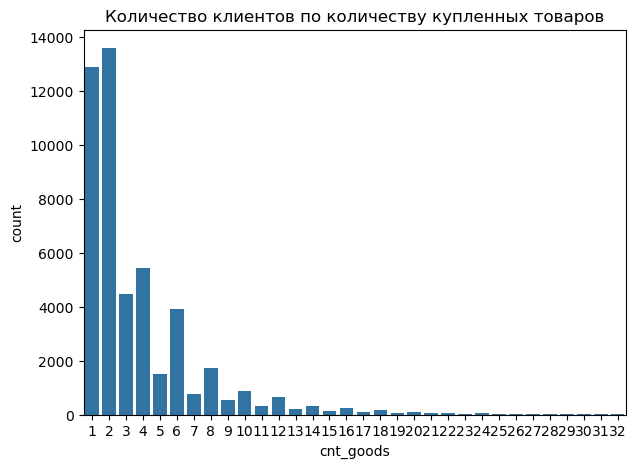

In [24]:
plt.subplots(figsize=(7, 5))
sns.countplot(x ='cnt_goods', data = data)
plt.title('Количество клиентов по количеству купленных товаров');

Из графика видно, что распределение клиентов по количеству покупок положительно ассиметрично (с перекосом вправо). Чаще всего люди покупают 1 или 2 товара.
<br>Определим сколько всего была выручка у магазина за выгруженный период:

In [25]:
print(f'Выручка магазина за период: {apparel_purchases.price.sum()/10**6} млн.руб')  

Выручка магазина за период: 241.295113 млн.руб


Посмотрим на то, сколько клиенты покупают за раз:

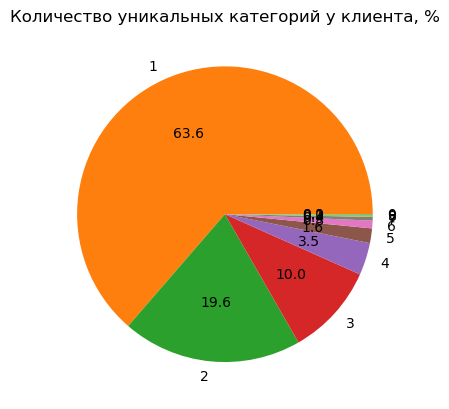

In [26]:
temp = data.pivot_table(index='nunique_cats', values='client_id', aggfunc='count')
plt.pie(temp.client_id, autopct='%.1f', labels=temp.index)
plt.title('Количество уникальных категорий у клиента, %');

Видно, что в подавляющем большинстве случаев люди покупают только одну или 2 категории товаров в данном магазине.
<br>Построим распределение клиентов по выручке, средней и максимальной цене покупки товара и действиям с сообщением:

In [27]:
data.head()

,client_id,cnt_goods,revenue,median_price,purchase_count,nunique_cats,cnt_message,days_between_buys,last_buy,message_cnt,events,bulk_campaign,channels,days_between_mess,last_mess,target
0,1515915625468060902,7,6993.0,999.0,7,5,1,0 days,630 days,177.0,5.0,127.0,1.0,610 days,27 days,0
1,1515915625468061003,7,16235.0,2100.0,7,1,1,0 days,408 days,165.0,4.0,154.0,1.0,634 days,2 days,1
3,1515915625468061100,2,2098.0,1049.0,2,1,1,0 days,6 days,428.0,6.0,265.0,1.0,637 days,0 days,0
4,1515915625468061170,19,33601.0,2195.0,19,3,3,83 days,244 days,293.0,4.0,240.0,2.0,631 days,0 days,0
5,1515915625468061514,1,999.0,999.0,1,1,1,0 days,566 days,180.0,4.0,150.0,1.0,629 days,2 days,0


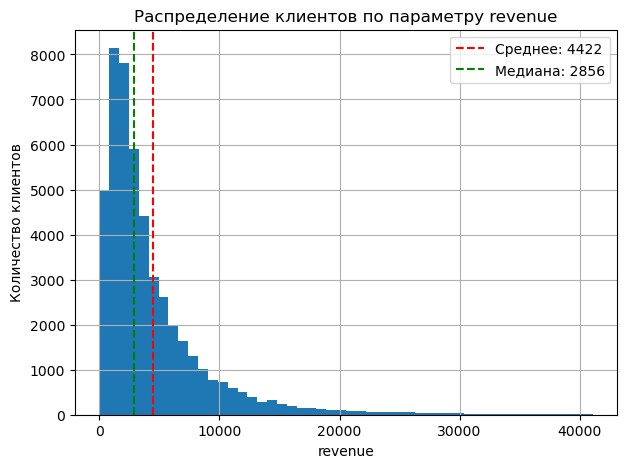

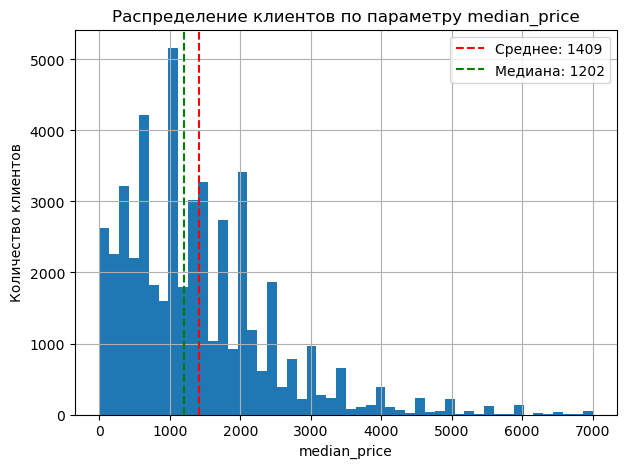

In [28]:
temp = ['revenue', 'median_price']

for i in temp:
    mean = round(data[i].mean())
    median = round(data[i].median())
        
    data[i].hist(bins=50, figsize=(7, 5))
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1.5, label=f'Среднее: {mean}')
    plt.axvline(median, color='g', linestyle='dashed', linewidth=1.5, label=f'Медиана: {median}')
    plt.title(f'Распределение клиентов по параметру {i}')
    plt.xlabel(i)
    plt.ylabel('Количество клиентов')
    plt.legend()
    plt.show()

Распределение клиентов по по выручке также положительно ассиметрично как и распределение по количеству покупок. Для цены товаров имеются значения сильно выбивающиеся из ряда цен. Наиболее популярная цена товара - 1000. Если измерение идет в рублях, то очевидно, что данные взяты не из брендового магазина одежды.
<br>Посмотрим на то, сколько рассылок получали клиенты:

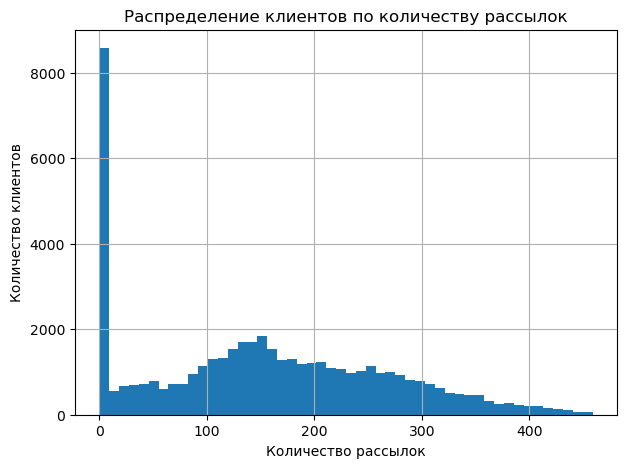

In [29]:
data['bulk_campaign'].hist(bins=50, figsize=(7, 5))
plt.title(f'Распределение клиентов по количеству рассылок')
plt.xlabel('Количество рассылок')
plt.ylabel('Количество клиентов')
plt.show()

Есть большое количество клиентов, которые получали рассылок около нуля. Скорее всего это связано с тем, что многие клиенты делали покупки не под воздействием рекламы.
<br>Посмотрим на корреляцию признаков между собой:

In [30]:
interval_cols = list(data._get_numeric_data().columns)
phik_overview = data.phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape) 

(16, 16)


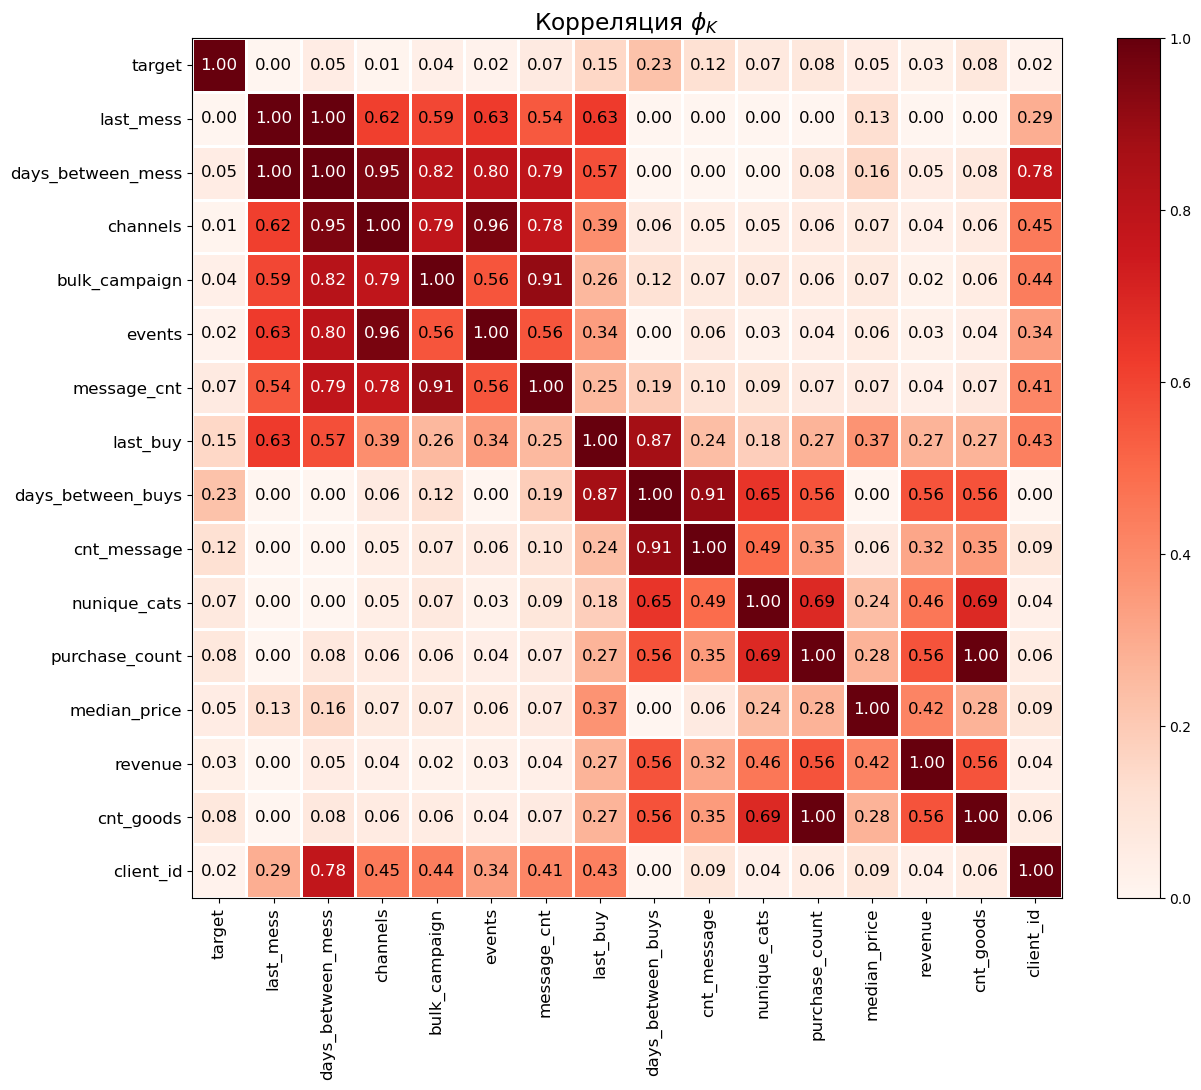

In [31]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.2,
    figsize=(13, 11)) 

In [32]:
data.head(1)

,client_id,cnt_goods,revenue,median_price,purchase_count,nunique_cats,cnt_message,days_between_buys,last_buy,message_cnt,events,bulk_campaign,channels,days_between_mess,last_mess,target
0,1515915625468060902,7,6993.0,999.0,7,5,1,0 days,630 days,177.0,5.0,127.0,1.0,610 days,27 days,0


Во-первых можно заметить, что с таргетом ничего серьезно не коррелирует. Информация из начальных датасетов также не связана друг с другом. из итогового датасета удалим колонки: **days_between_mess**, **channels**, **message_cnt**, **cnt_message**, **purchase_count**, **clien_id**.

In [33]:
data_final = data.drop([ 'channels', 'cnt_message', 'purchase_count', 'client_id'], axis=1)

In [34]:
data_final

,cnt_goods,revenue,median_price,nunique_cats,days_between_buys,last_buy,message_cnt,events,bulk_campaign,days_between_mess,last_mess,target
0,7,6993.0,999.0,5,0 days,630 days,177.0,5.0,127.0,610 days,27 days,0
1,7,16235.0,2100.0,1,0 days,408 days,165.0,4.0,154.0,634 days,2 days,1
3,2,2098.0,1049.0,1,0 days,6 days,428.0,6.0,265.0,637 days,0 days,0
4,19,33601.0,2195.0,3,83 days,244 days,293.0,4.0,240.0,631 days,0 days,0
5,1,999.0,999.0,1,0 days,566 days,180.0,4.0,150.0,629 days,2 days,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49844,6,8994.0,1499.0,1,0 days,0 days,3.0,3.0,1.0,0 days,0 days,0
49845,2,1818.0,909.0,1,0 days,2 days,0.0,0.0,0.0,0 days,0 days,0
49846,2,198.0,99.0,1,0 days,0 days,0.0,0.0,0.0,0 days,0 days,0
49847,1,1999.0,1999.0,1,0 days,0 days,0.0,0.0,0.0,0 days,0 days,0


## Подготовка данных и выбор модели 

In [35]:
X = data_final.drop('target', axis=1)
y = data_final['target']

# Масштабирование числовых признаков
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Обработка столбцов с датами
time_cols = X_train.select_dtypes(include=['timedelta64[ns]']).columns
for i in time_cols:
    X_train[i] = X_train[i].dt.days
    X_test[i] = X_test[i].dt.days

Выбирать модель будем из бустингов: LGBM и CatBoost:

In [37]:
pipe_final = Pipeline([('models', LGBMClassifier())])

In [38]:
param_grid = [
    # модель LGBMClassifier
    {'models': [LGBMClassifier()],
     'models__n_estimators': [1000, 1500],
     'models__max_depth': [10, 15]},
    
    # модель CatBoostClassifier
     {'models': [CatBoostClassifier(silent=True)],
      'models__iterations': [100, 200]}
]

In [39]:
# Выбор лучшей модели и оценка по метрике roc_auc
best_model = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1)

In [40]:
best_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('models', LGBMClassifier())]),
             n_jobs=-1,
             param_grid=[{'models': [LGBMClassifier()],
                          'models__max_depth': [10, 15],
                          'models__n_estimators': [1000, 1500]},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x77139961de50>],
                          'models__iterations': [100, 200]}],
             scoring='roc_auc')

In [48]:
print(f'Лучшая roc_auc на тестовых данных: {best_model.best_score_}')

Лучшая roc_auc на тестовых данных: 0.6997325019595785


In [42]:
pred = best_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, pred)

0.7104719200235224

In [43]:
# посомтрим, сколько классов получили значение 1

lst = 0

for i in pred:
    if i>0.5:
        lst += 1
lst

3

Лучшей моделью оказалась CatBoost. Метрика roc_auc выше, чем граничная (0.7), хотя это из-за того, что почти всем она присвоила 0. При присвоении вообще всем клиентам 0, roc_auc равнялась бы 0.5. Следует использовать другие метрики для данного задания, наприме F-меру. Модель, с целью поднятия roc_auc, старается как можно реже присвоить класс 1.

## Анализ важности признаков

In [44]:
def feature_importanses(model):

    '''Функция для вывода 5 самых важных признаков модели'''
    
    features = {'feature': X_train.columns, 'weight': model.feature_importances_}
    return pd.DataFrame(features).sort_values(by='weight', ascending=False).head(5)

In [45]:
model = CatBoostClassifier(silent=True)

In [46]:
model.fit(X_train, y_train)

In [47]:
feature_importanses(model)

,feature,weight
5,last_buy,19.268688
8,bulk_campaign,11.621612
6,message_cnt,11.266428
1,revenue,11.055671
2,median_price,10.640322


Среди самых важных признаков оказались: сколько дней назад была последняя покупка, количество рассылок, количество сообщений для купивших клиентов, выручка от одного клиента и медианная уена покупок.